In [10]:
import importlib
import os
from pathlib import Path

import numpy as np
import pandas as pd

import config
import module
from tests import test

for p in [config, module, test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

In [11]:
df_coco_member = pd.read_excel(config.path_coco_member)

In [12]:
# create a date range from jan 2023 to current month
# create a date range from jan 2023 to current month in a readable format
date_ranges = module.create_eom_date_ranges("2023-01", config.month)
month_ranges = [i.strftime("%Y-%m").lower() for i in date_ranges]

# list of all att files
att_files = [
    f"{config.path_attendance_data_parent}/2023/{i}/data-attendance-{i}.xlsx"
    for i in month_ranges
]
att_files = att_files + [
    f"{config.path_attendance_data_parent}/2024/{i}/data-attendance-{i}.xlsx"
    for i in month_ranges
]

# get all att files and concat
dfs = []
cols_to_use = ["student_code", "class_date", "student_attendance"]
for file in att_files:
    try:
        dfs.append(pd.read_excel(file, usecols=cols_to_use))
    except FileNotFoundError:
        pass

df_att_all_mo = pd.concat(dfs, ignore_index=True)
print(len(date_ranges), len(dfs))

16 16


In [13]:
cohort_start_date = (
    pd.to_datetime(config.month, format="%Y-%m")
    - pd.Timedelta(days=330)
    - pd.offsets.MonthBegin(1)  # make this the beginning of the month
)
cohort_end_date = (
    pd.to_datetime(config.month, format="%Y-%m")
    + pd.offsets.MonthEnd(0)  # make this the end of the month
)
print(f"cohort start :{cohort_start_date: '%d %b %Y'}, cohort end :{cohort_end_date: '%d %b %Y'}")

cohort start : '01 May 2023', cohort end : '30 Apr 2024'


In [33]:
# the date on which the member join
df_member_clean = (
    df_coco_member
    .rename(columns={"start_date": "date"})
    .assign(is_first=True)
    # loc date between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date),
        ["student_code", "date", "is_first"],
    ]
)
df_member_clean.head()
# df_member_clean.loc[
#     (df_member_clean["date"].dt.month == 2)
#     & (df_member_clean["date"].dt.year == 2024)
# ]

,student_code,date,is_first
0,MARIO (GO) ANDRI - 4046,2023-11-08,True
2,PRATOMO (GO) DODDY NUR - 4374,2024-02-29,True
3,YANUARI (GO CPT CTI GROUP) DANIEL EKO - 3792,2023-08-25,True
4,TJ (GO) RR SOEFRIANTY - 4413,2024-03-20,True
5,TJANDRA (GO) THOMAS - 3693,2023-07-28,True


In [40]:
# attendance of all member
df_att_all_mo_clean = (
    df_att_all_mo
    .loc[lambda df_: df_["student_attendance"] == "Attend"]  # only attend
    .drop(columns=["student_attendance"])
    .rename(columns={"class_date": "date"})
    # loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date)
    ]
    # only include members who are in df_member_clean
    # else, old members who started before that will be in the data
    .loc[lambda df_: df_["student_code"].isin(
        df_member_clean["student_code"].unique()
    )]
)
df_att_all_mo_clean.head()

,date,student_code
84953,2023-05-01,INDIARTI SE MM (VIP) LINA - 7947
85035,2023-05-01,DWI PRAPMANTO (GO) ANDIKA MULYAWAN - 3337
85048,2023-05-01,(GO) NURBAETI - 1338
85061,2023-05-01,GUNAWAN (CPT PT. BAYAN RESOURCES TBK) LILY - 9438
85115,2023-05-01,RAHMI ELSA NABILA - 5843


In [41]:
# concat att and member
df_cohort_raw = (
    pd.concat([df_member_clean, df_att_all_mo_clean])
    # drop the same date
    .sort_values(["is_first", "date"])
    .drop_duplicates(subset=["student_code", "date"], keep="first")
    # .drop(columns=["is_first"])
    .assign(date=lambda df_: pd.to_datetime(df_["date"]))
    .rename(columns={
        "student_code": "customer_id",
        "date": "transaction_date"
    })
    .merge(
        right=(
            df_coco_member
            .sort_values("start_date", ascending=True)
            .drop_duplicates(subset=["student_code"])
        ), 
        left_on="customer_id", 
        right_on="student_code", 
        how="left", 
        validate="many_to_one"
    )
    .loc[:, ["customer_id", "transaction_date", "student_membership", "is_first"]]
)
df_cohort_raw.head()

,customer_id,transaction_date,student_membership,is_first
0,SUHENDI (GO) DIKI - 3366,2023-05-01,Go,True
1,DWI PRAPMANTO (GO) ANDIKA MULYAWAN - 3337,2023-05-01,Go,True
2,BAGASKARA (DLX GC) DAFFA ABYAN - 9524,2023-05-01,Deluxe,True
3,INDIARTI SE MM (VIP) LINA - 7947,2023-05-01,VIP,True
4,AL QOSAM (DLX PP) MUHAMMAD IZZUDDIN - 9528,2023-05-01,Deluxe,True


In [51]:
def make_cohort(df: pd.DataFrame) -> pd.DataFrame:
    """Do a cohort analysis on a DF.

    :param pd.DataFrame df: DF with two cols
        ["transaction_date", "customer_id"].
    :return pd.DataFrame: A pivoted DF with cohort.
    """

    def get_days_after_first_transaction(
        trans_date_ser: pd.Series, first_trans_date_ser: pd.Series
    ):
        """Get days between transaction and first transaction,
        binned with a width of 30, from 0 to 360 days.

        :param pd.Series trans_date_ser: transaction date
        :param pd.Series first_trans_date_ser: first transaction date
        :return pd.Series: day between, binned into a bin of width = 30
        """
        return pd.cut(
            (
                pd.to_datetime(trans_date_ser) - pd.to_datetime(first_trans_date_ser)
            ).dt.days,
            bins=list(range(0, 390, 30)),
            include_lowest=True,
        )

    def ffill_1d_arr(arr: np.array) -> np.array:
        """Forward fill a 1D numpy array.

        :param np.array arr: Array to process.
        :return np.array: Resulting array.
        """
        arr_copy = arr.copy()
        arr_shape = arr_copy.shape
        last_seen = None
        for i in range(arr_shape[0]):
            current_val = arr_copy[i]
            if not np.isnan(current_val):
                last_seen = current_val
            elif np.isnan(current_val):
                arr_copy[i] = last_seen
        return arr_copy

    def get_customer_first_month(
        flag_series: pd.Series, fill_series: pd.Series
    ) -> pd.Series:
        """Get the number of first customer in a cohort.

        :param pd.Series flag_series: Values that specify the month of customer.
        :param pd.Series fill_series: Values used to fill.
        :return pd.Series: The number of customer on the first month
        for each cohort, filled with ffill.
        """
        result = np.where(
            flag_series.astype(str) == "(-0.001, 30.0]",
            fill_series,
            np.nan,
        )
        return ffill_1d_arr(result)

    def fillna_diagonal_lower_right(df: pd.DataFrame) -> pd.DataFrame:
        """Change the value of bottom right diagonal with nan.

        :param pd.DataFrame df: DF with shape a*a.
        :return pd.DataFrame: DF with bottom right diagonal nan.
        """
        df = df.astype(float)
        rows, cols = np.tril_indices(len(df), k=-1)
        reversed_cols = len(df) - 1 - cols
        df.values[rows, reversed_cols] = np.nan
        return df

    df_result = (
        df.sort_values(["transaction_date", "customer_id"])
        .assign(
            # customer first purchase
            first_purchase=lambda df_: (
                df_.groupby(["customer_id"])["transaction_date"].transform("min")
            ),
            # distance betweeen first purchase and transaction date
            # bin this to a series of 30 days
            days_after_first_transaction=lambda df_: get_days_after_first_transaction(
                pd.to_datetime(df_["transaction_date"]),
                pd.to_datetime(df_["first_purchase"]),
            ),
        )
        .groupby(
            [
                # get first purchase in a monthly basis
                pd.Grouper(key="first_purchase", freq="M"),
                "days_after_first_transaction",
            ],
            observed=False,
        )
        .agg(num_cust=("customer_id", "nunique"))
        .assign(
            # get the initial number of customer for denominator
            num_cust_first_month=lambda df_: get_customer_first_month(
                df_.index.get_level_values("days_after_first_transaction"),
                df_["num_cust"],
            ),
            # get the percentage of each month relative to month 0
            percentage_to_num_cust_first_month=lambda df_: (
                df_["num_cust"].div(df_["num_cust_first_month"])
            ),
        )
        # pivot
        .reset_index()
        .pivot(
            index="first_purchase",
            columns="days_after_first_transaction",
            values="percentage_to_num_cust_first_month",
        )
        # fillna in case if there is month without buyer
        # however, this will fill the lower right diagonal with 0
        .fillna(0)
        # fill diagonal with na again
        .pipe(fillna_diagonal_lower_right)
        .replace(0, np.nan)
        # rename axis
        .rename_axis("Months after Join", axis=1)
        .rename_axis("Join", axis=0)
    )
    # format the index to human readable format
    df_result.index = pd.to_datetime(df_result.index).strftime("%b %Y")

    # get average per months after transaction
    df_result = (
        df_result.transpose().assign(Average=lambda df_: df_.mean(axis=1)).transpose()
    )

    return df_result

# make_cohort(df_cohort_raw)

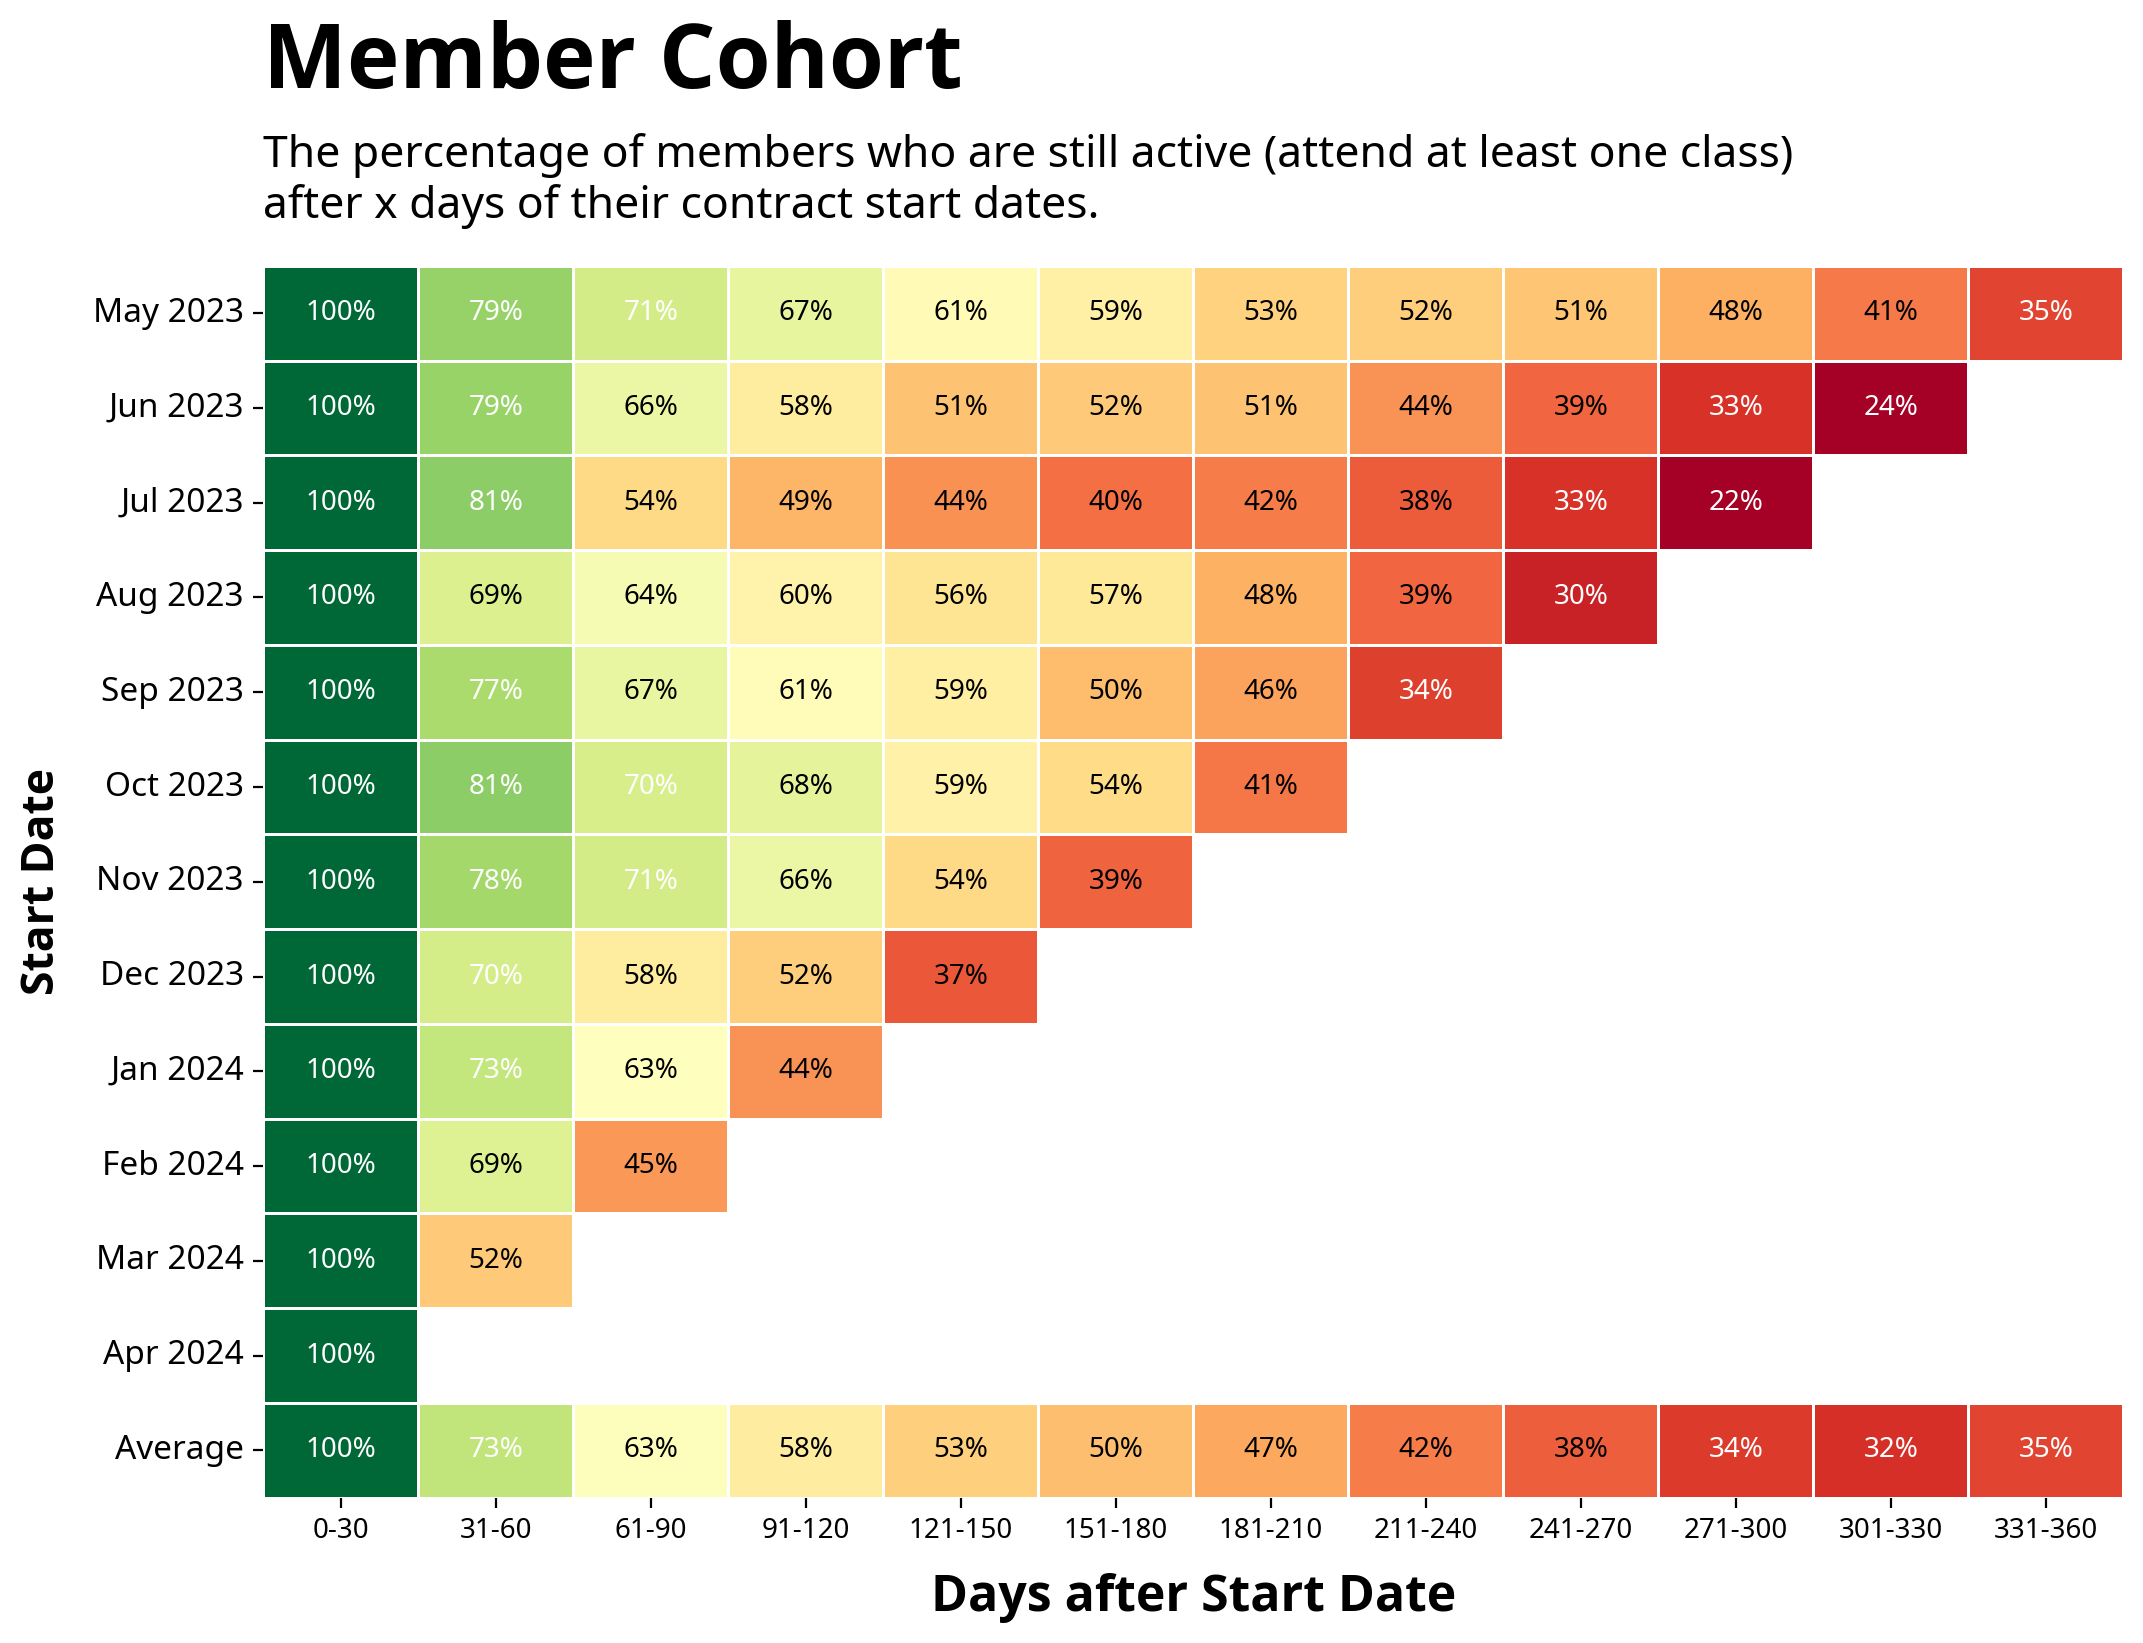

In [52]:
module.plot_cohort(make_cohort(df_cohort_raw), title=f"Member Cohort")

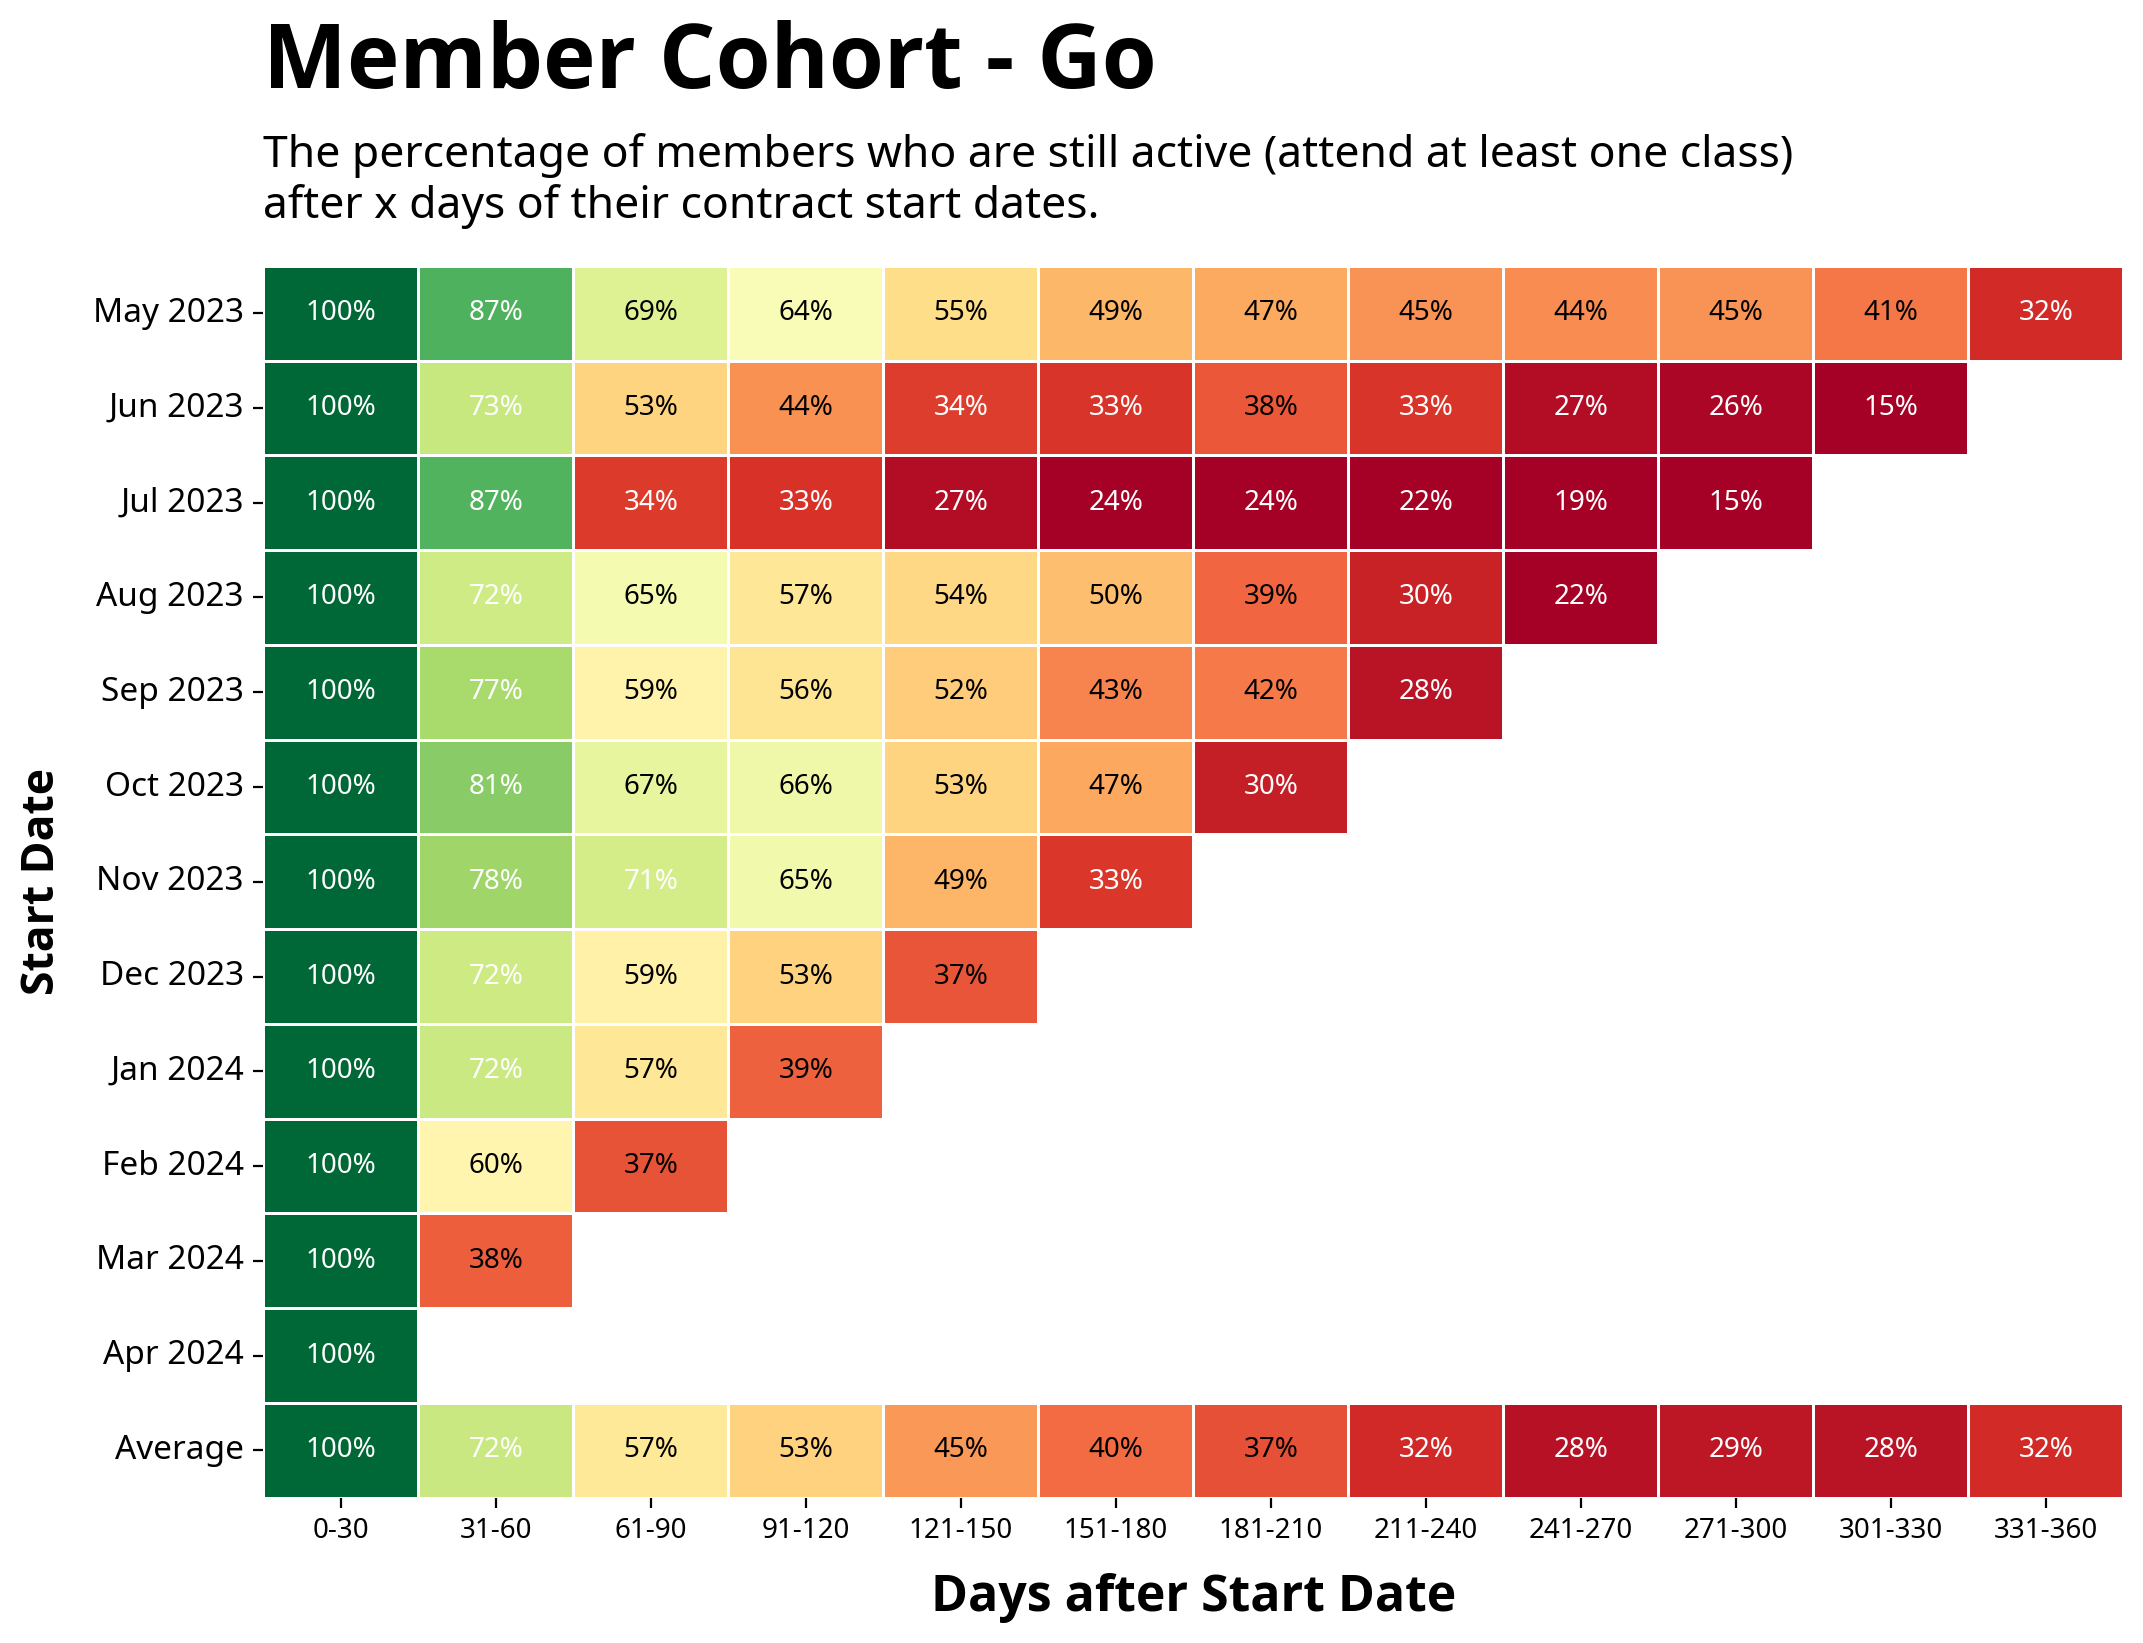

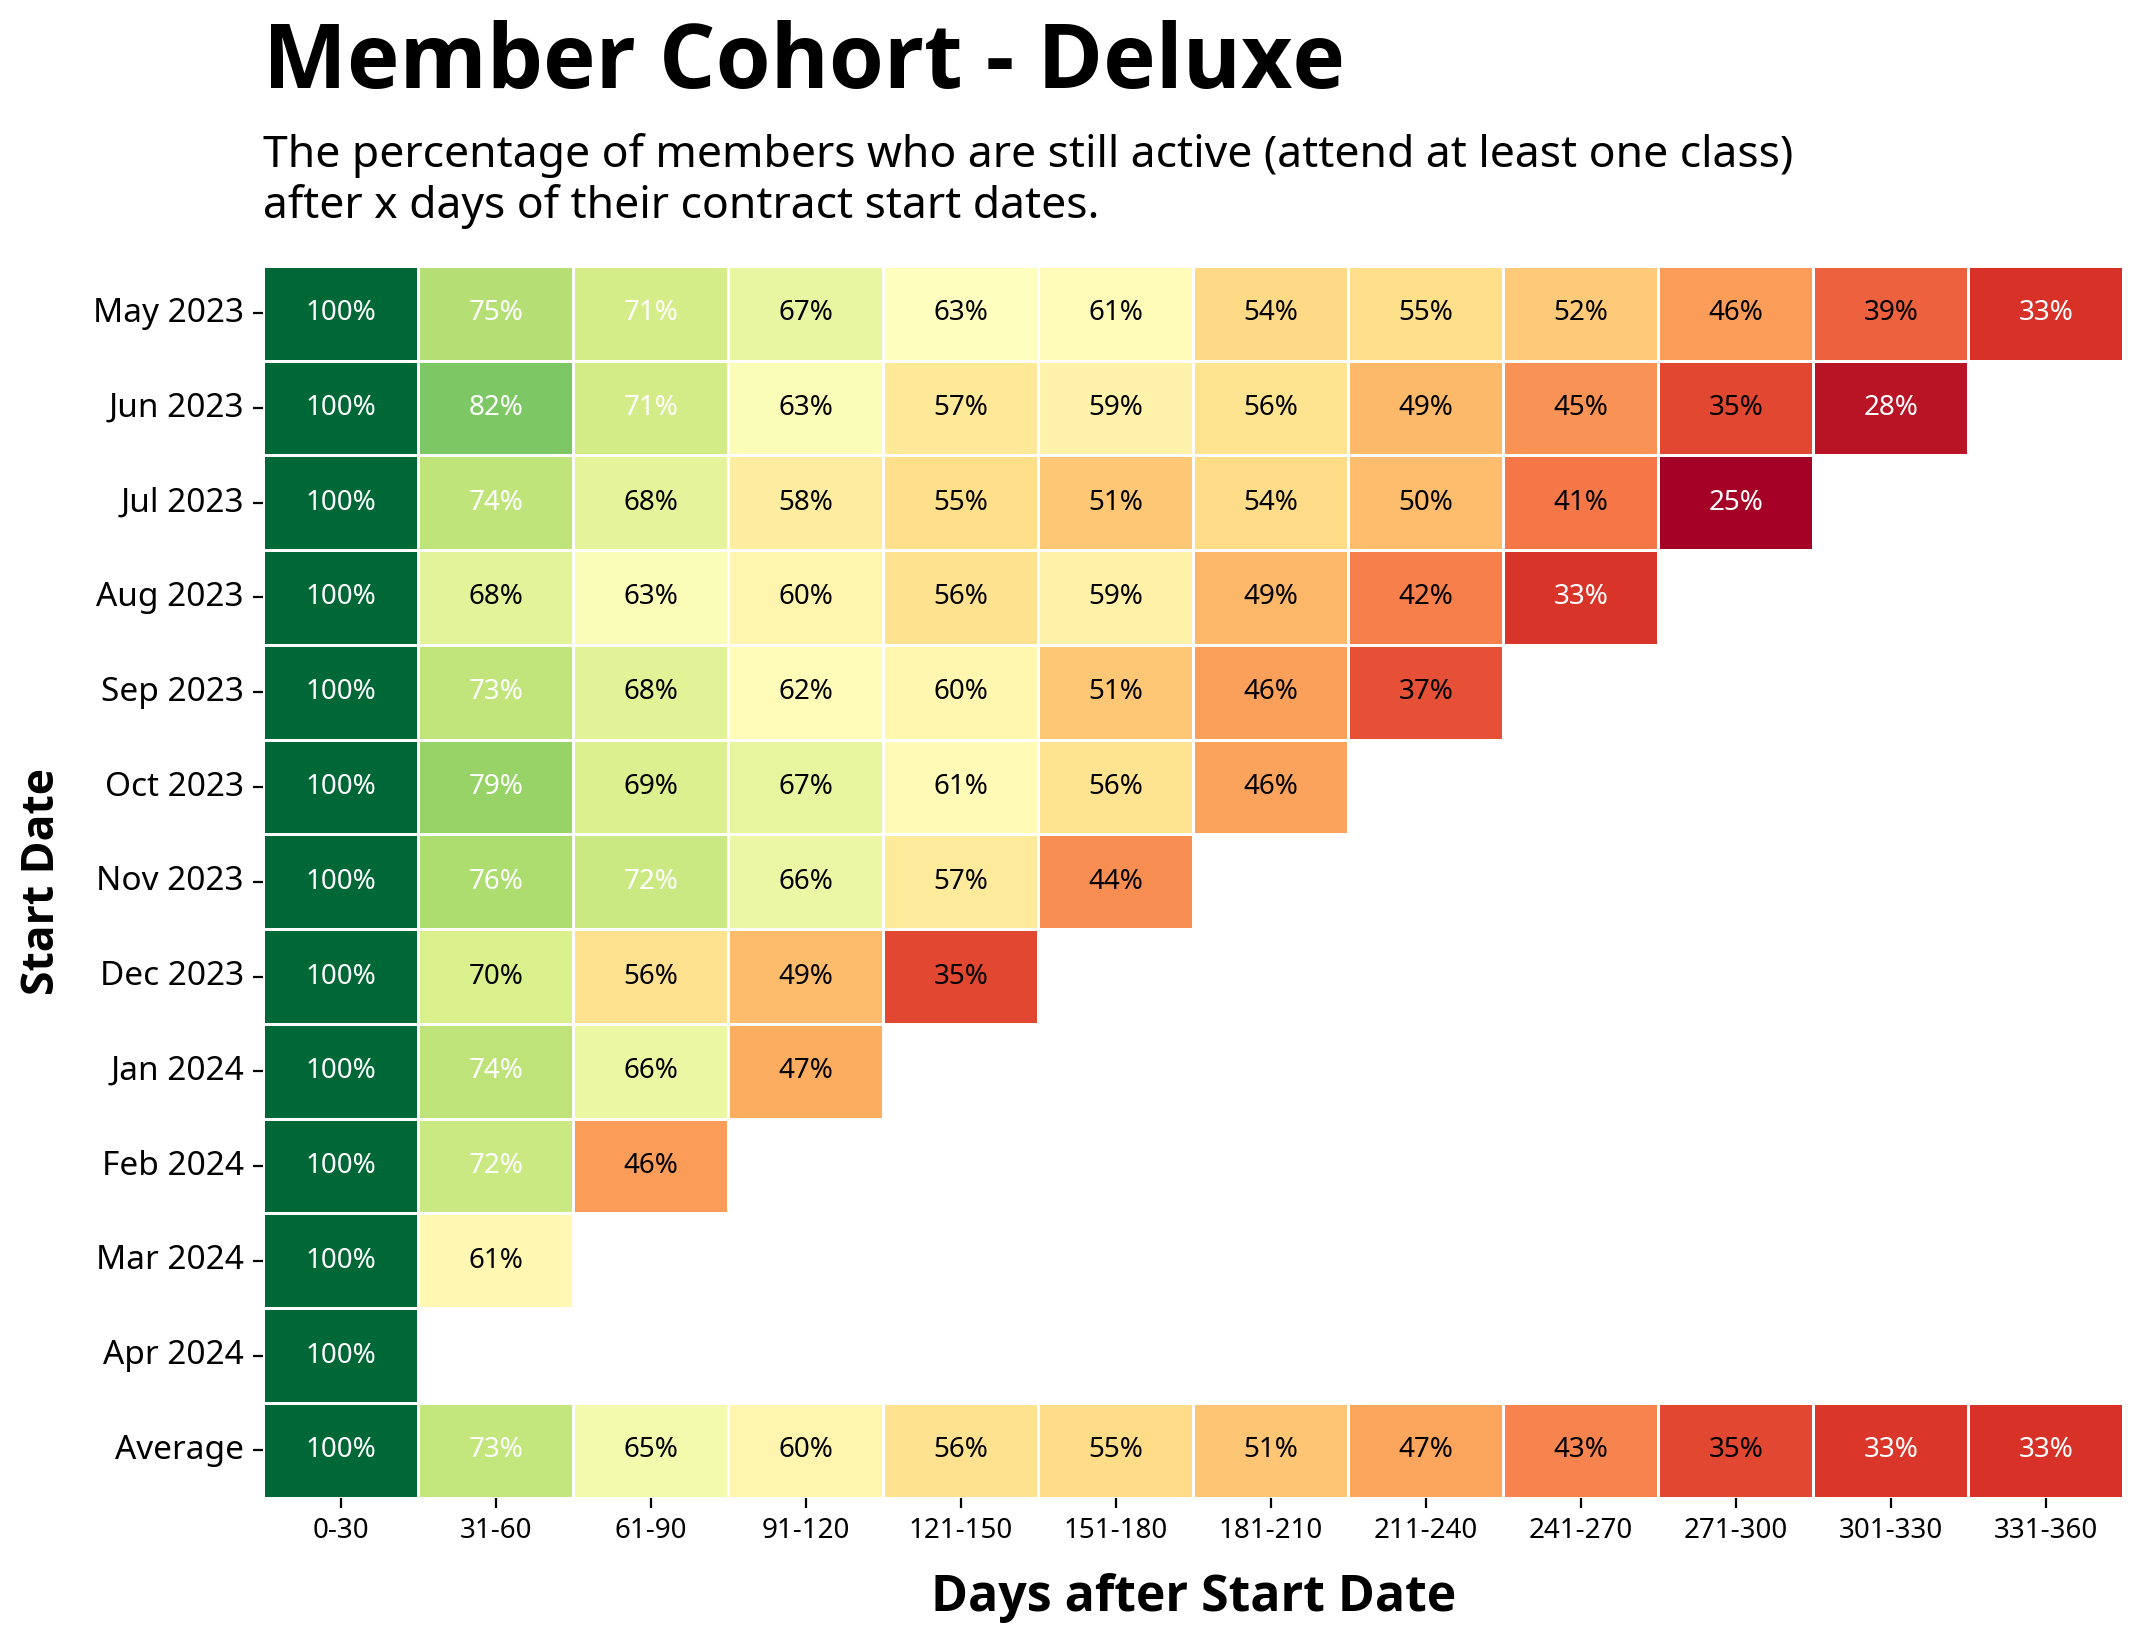

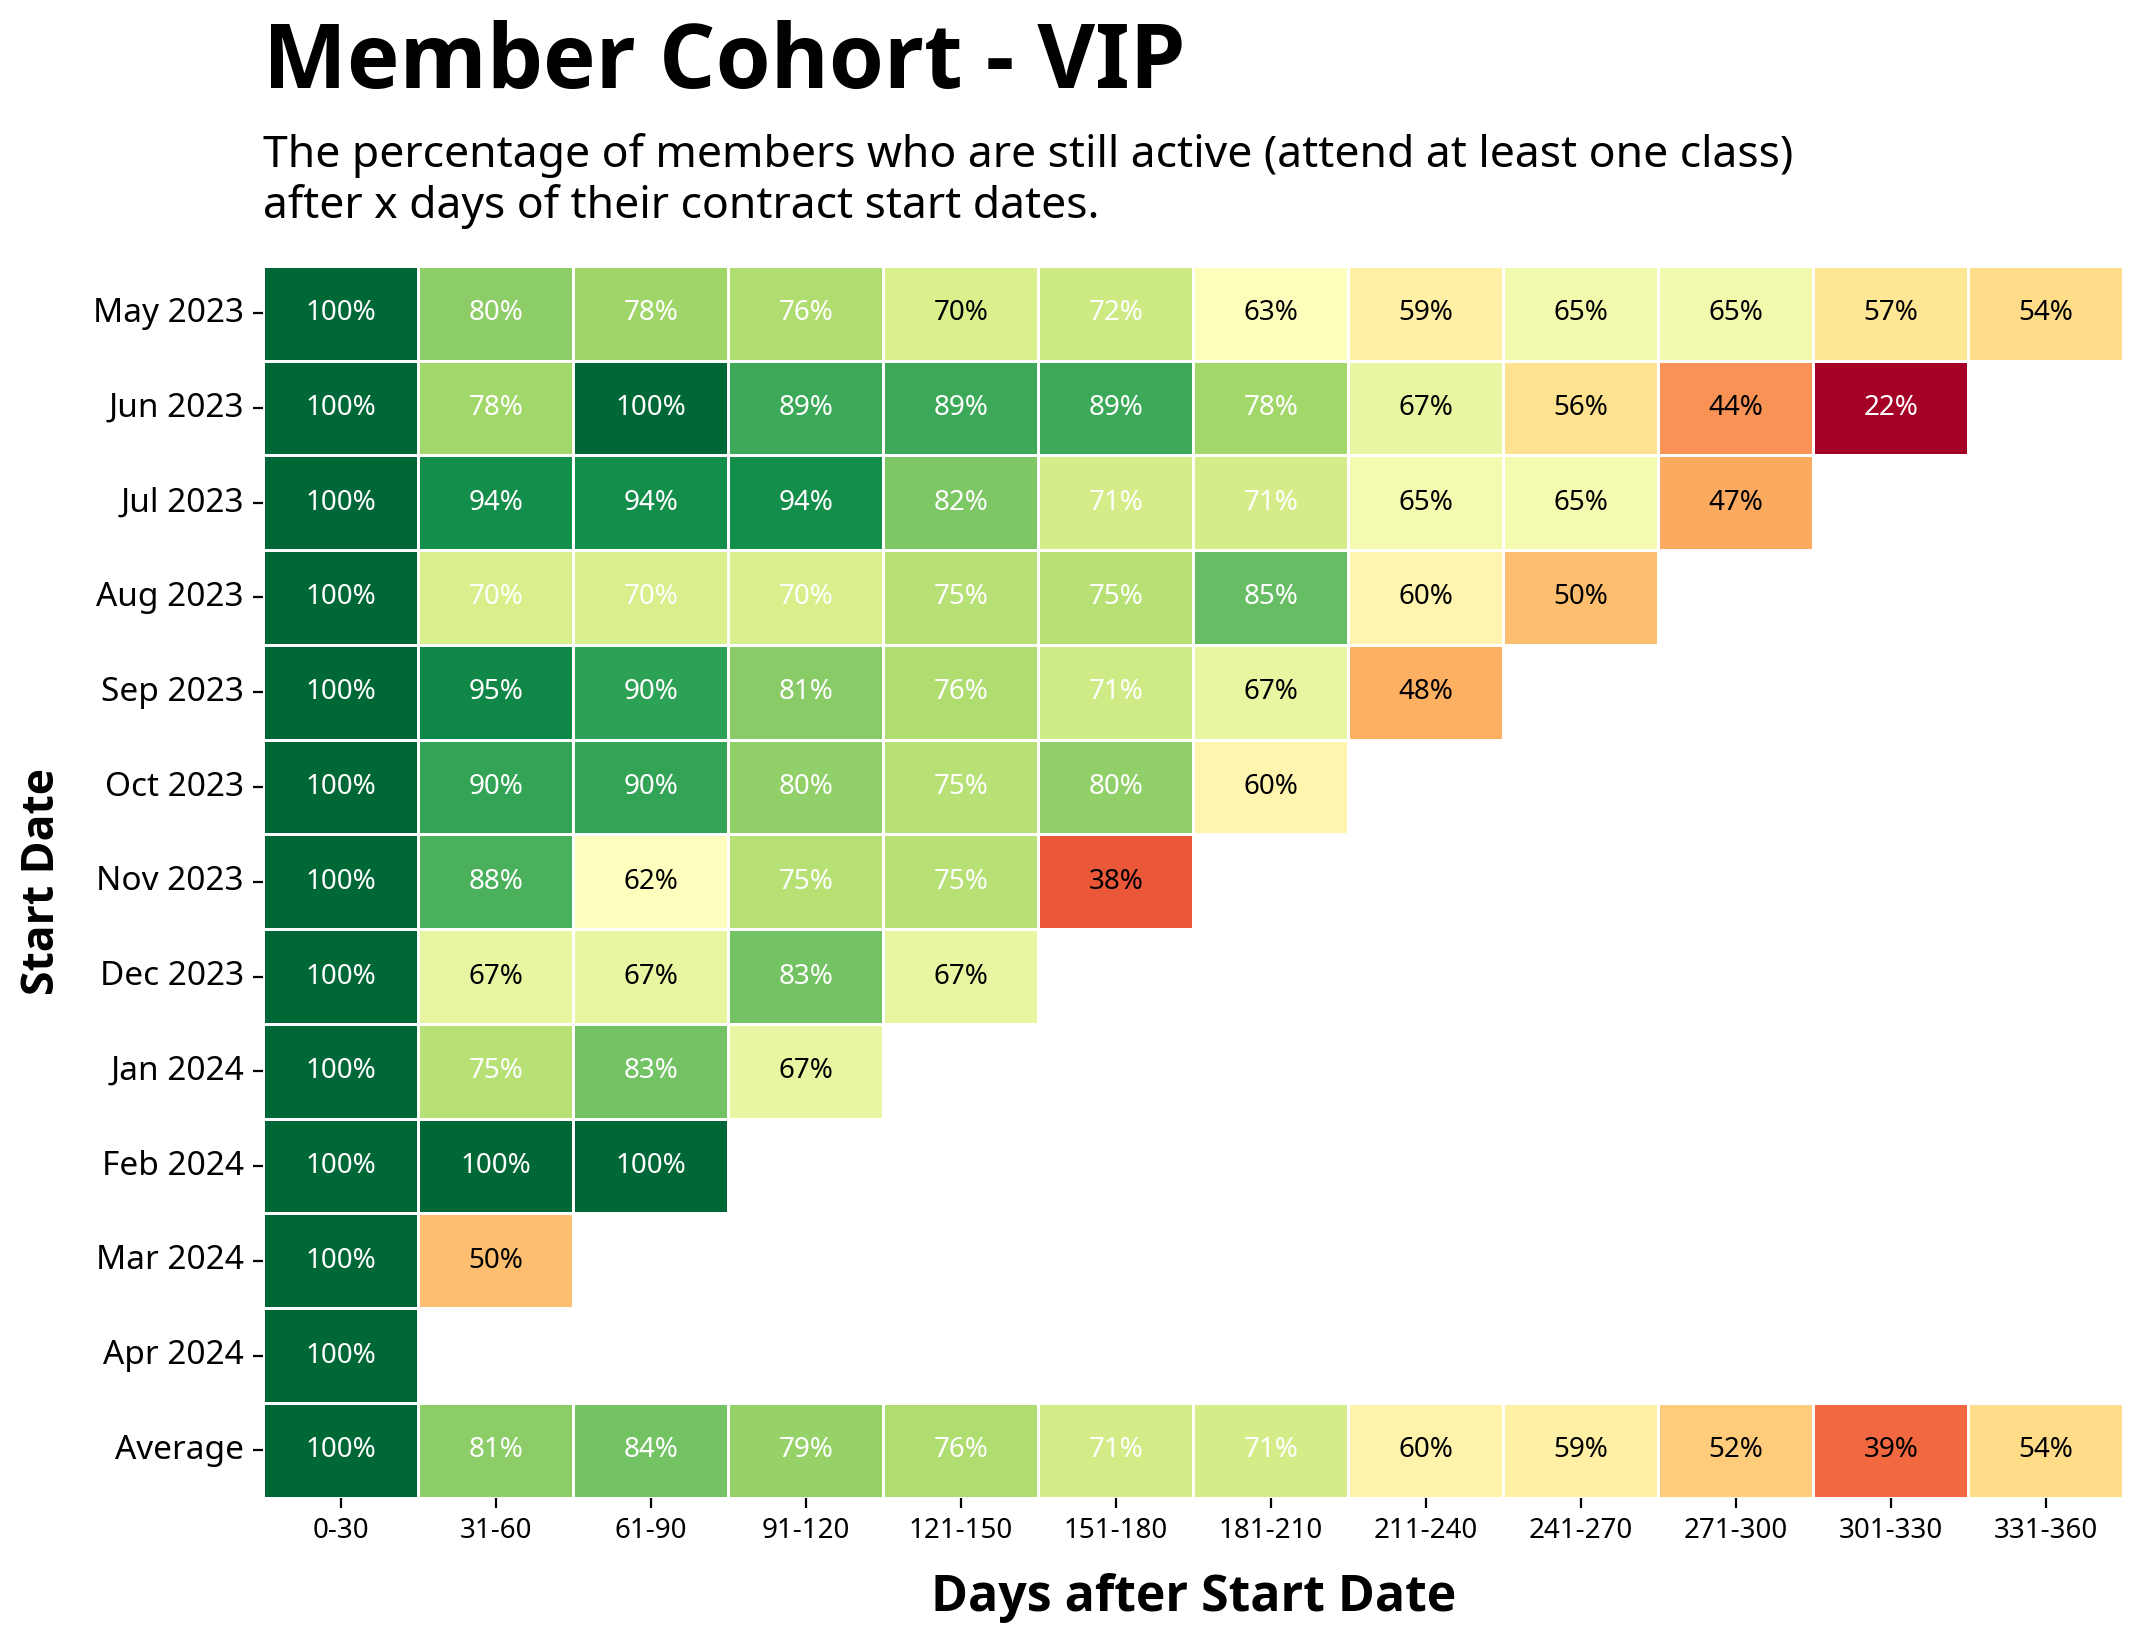

In [53]:
for membership in df_cohort_raw["student_membership"].unique():
    df_cohort = make_cohort(df_cohort_raw.loc[df_cohort_raw["student_membership"] == membership])
    module.plot_cohort(df_cohort, title=f"Member Cohort - {membership}")